In [30]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [31]:
full_train=pd.read_parquet("C:\\Users\\USER\\DS230_Final_Project\\data\\processed\\full_train.parquet")
full_priors=pd.read_parquet("C:\\Users\\USER\\DS230_Final_Project\\data\\processed\\full_priors.parquet")

we will use full_priors for feature engineering since it has the prior orders for each user and then merge full_train with these features for modeling

## User-level features

In [32]:
total_orders=full_priors.groupby('user_id')['order_id'].nunique().rename('total_orders').reset_index()
avg_basket_size=full_priors.groupby(['user_id','order_id']).size().groupby('user_id').mean().rename('avg_basket_size').reset_index()
reorder_ratio=full_priors.groupby('user_id')['reordered'].mean().rename("reorder_ratio").reset_index()
mean_days_between_orders=full_priors.groupby('user_id')['days_since_prior_order'].mean().rename('mean_days_between_orders').reset_index()
last_order_recency=full_priors.sort_values(['user_id', 'order_number']).groupby('user_id')['days_since_prior_order_winsor'].last().rename('last_order_recency').reset_index()

user_fet=(total_orders.merge(avg_basket_size, on='user_id', how='left').merge(reorder_ratio, on='user_id', how='left')
              .merge(mean_days_between_orders, on='user_id', how='left').merge(last_order_recency, on='user_id', how='left'))
user_fet.head()

,user_id,total_orders,avg_basket_size,reorder_ratio,mean_days_between_orders,last_order_recency
0,1,10,5.900000,0.694915,18.542374,29.0
1,2,14,13.928571,0.476923,14.902564,13.0
2,3,12,7.333333,0.625000,10.181818,15.0
3,4,5,3.600000,0.055556,11.944445,0.0
4,5,4,9.250000,0.378378,10.189189,19.0


## Product-level features

In [33]:
product_reorder_rate=full_priors.groupby('product_id')['reordered'].mean().rename('product_reorder_rate').reset_index()
avg_pos_in_cart=full_priors.groupby('product_id')['add_to_cart_order_winsor'].mean().rename('avg_pos_in_cart').reset_index()
product_avg_order=full_priors.groupby("product_id")['order_number'].mean().rename('product_popularity').reset_index() # product popularity

product_fet=product_reorder_rate.merge(avg_pos_in_cart,on='product_id',how='left').merge(product_avg_order,on='product_id',how='left')
product_fet.head()

,product_id,product_reorder_rate,avg_pos_in_cart,product_popularity
0,1,0.613391,5.673866,19.397408
1,2,0.133333,9.455556,25.666667
2,3,0.732852,6.176895,17.342960
3,4,0.446809,9.246201,9.027356
4,5,0.600000,6.466667,8.933333


## User×Product interaction features

In [34]:
prior_purchase_count=full_priors.groupby(['user_id','product_id']).size().rename('prior_purchase_count').reset_index()
days_since_last_purchase=(full_priors.sort_values(['user_id','product_id','order_number']).groupby(['user_id','product_id'])['days_since_prior_order_winsor']
                          .last().rename("days_since_last_purchase").reset_index())
avg_reorder_prob=full_priors.groupby(['user_id','product_id'])['reordered'].mean().rename('avg_reorder_prob').reset_index()

user_product_fet=prior_purchase_count.merge(days_since_last_purchase,on=['user_id','product_id'],how='left').merge(avg_reorder_prob,on=['user_id','product_id'],how='left')
user_product_fet.head()
                  

,user_id,product_id,prior_purchase_count,days_since_last_purchase,avg_reorder_prob
0,1,196,10,29.0,0.900000
1,1,10258,9,29.0,0.888889
2,1,10326,1,28.0,0.000000
3,1,12427,10,29.0,0.900000
4,1,13032,3,29.0,0.666667


## Temporal features

In [35]:
full_train['is_morning']=full_train['order_hour_of_day'].between(5, 11).astype(int)
full_train['is_afternoon']=full_train['order_hour_of_day'].between(12, 16).astype(int)
full_train['is_evening']=full_train['order_hour_of_day'].between(17, 20).astype(int)
full_train['is_night']=(~full_train['order_hour_of_day'].between(5, 20)).astype(int)

## Aggregations Over Windows
Average reorder rate over the user’s last 3 purchased products

In [36]:
last_3=full_priors.sort_values(['user_id', 'order_number']).groupby('user_id').tail(3)
avg_reorder_last_3=last_3.groupby('user_id')['reordered'].mean().rename('avg_reorder_last_3').reset_index()

## Merging full_train with engineered features

In [37]:
full_train=full_train.merge(user_fet,on='user_id',how='left').merge(product_fet,on='product_id',how='left')
full_train=full_train.merge(user_product_fet,on=['user_id','product_id'],how='left').merge(avg_reorder_last_3,on='user_id',how='left')
full_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,reorder_ratio,mean_days_between_orders,last_order_recency,product_reorder_rate,avg_pos_in_cart,product_popularity,prior_purchase_count,days_since_last_purchase,avg_reorder_prob,avg_reorder_last_3
0,1,49302,1,1,112108,train,4,4,10,9.0,...,0.428571,6.238095,15.0,0.619632,6.361963,19.625767,2.0,7.0,0.5,0.666667
1,1,11109,2,1,112108,train,4,4,10,9.0,...,0.428571,6.238095,15.0,0.713775,7.208855,18.642665,2.0,7.0,0.5,0.666667
2,1,10246,3,0,112108,train,4,4,10,9.0,...,0.428571,6.238095,15.0,0.524553,9.243809,19.814572,NaN,NaN,NaN,0.666667
3,1,49683,4,0,112108,train,4,4,10,9.0,...,0.428571,6.238095,15.0,0.691702,7.507157,14.919529,NaN,NaN,NaN,0.666667
4,1,43633,5,1,112108,train,4,4,10,9.0,...,0.428571,6.238095,15.0,0.477795,8.777948,14.926493,2.0,15.0,0.5,0.666667


In [38]:
full_train.isna().sum()[full_train.isna().sum()>0]


product_reorder_rate             9
avg_pos_in_cart                  9
product_popularity               9
prior_purchase_count        555793
days_since_last_purchase    555793
avg_reorder_prob            555793
dtype: int64

missing values appeared because some users,products weren't in full_priors so missing values were filled with zero, indicating the absence of prior data 

In [39]:
full_train=full_train.fillna(0)
print('Number of Missing Values:',full_train.isna().sum().sum())

Number of Missing Values: 0


## Log Transform

In [41]:
full_train.skew(numeric_only=True).sort_values(ascending=False)[full_train.skew(numeric_only=True).sort_values(ascending=False)>1]


prior_purchase_count        4.255405
is_night                    3.266088
total_orders                2.243372
order_number                2.243372
add_to_cart_order           1.685549
is_evening                  1.524837
avg_basket_size             1.183549
add_to_cart_order_winsor    1.005774
dtype: float64

Text(0.5, 1.0, 'Distribution of Total Orders\n(before log1p)')

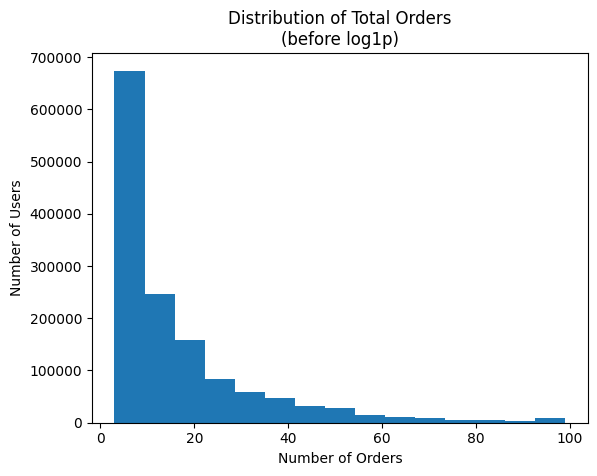

In [42]:
plt.hist(full_train['total_orders'],bins=15)
plt.xlabel('Number of Orders')
plt.ylabel('Number of Users')
plt.title('Distribution of Total Orders\n(before log1p)')

We used log1p instead of log to handle zero values

Text(0.5, 1.0, 'Distribution of Total Orders\n(after log1p)')

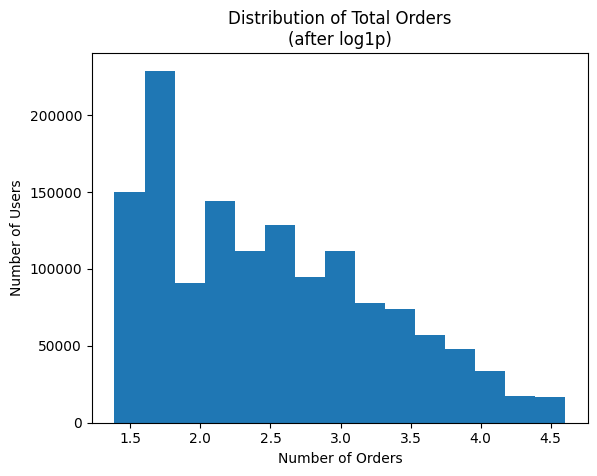

In [43]:
full_train['total_orders']=np.log1p(full_train['total_orders'])

plt.hist(full_train['total_orders'],bins=15)
plt.xlabel('Number of Orders')
plt.ylabel('Number of Users')
plt.title('Distribution of Total Orders\n(after log1p)')